In [1]:
# Traffic-Net Image Classification Pipeline
# Complete ML Workflow with Training, Evaluation, and Deployment

# ============================================================================
# 1. IMPORT LIBRARIES
# ============================================================================

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import cv2
import os
from pathlib import Path
import json
import pickle
from datetime import datetime

import kagglehub

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:

# Download dataset
path = kagglehub.dataset_download("umairshahpirzada/traffic-net")

# Kaggle dataset path
KAGGLE_DIR = Path(path)
BASE_DIR = KAGGLE_DIR / "trafficnet_dataset_v1"

TRAIN_DIR = BASE_DIR / "train"
TEST_DIR = BASE_DIR / "test"

MODEL_DIR = Path("../models")
MODEL_DIR.mkdir(exist_ok=True)

print("Dataset path:", BASE_DIR.resolve())

# Class names must match EXACT folder names in the dataset
CLASS_NAMES = ["sparse_traffic", "dense_traffic", "accident", "fire"]

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50


# Create directory structure if needed
for split in ['train', 'test']:
    for class_name in CLASS_NAMES:
        (BASE_DIR / split / class_name).mkdir(parents=True, exist_ok=True)

# Function to count images in dataset
def count_images(directory):
    counts = {}
    total = 0
    for class_name in CLASS_NAMES:
        class_path = directory / class_name
        if class_path.exists():
            count = len(list(class_path.glob('*.jpg'))) + len(list(class_path.glob('*.png')))
            counts[class_name] = count
            total += count
    return counts, total

train_counts, train_total = count_images(TRAIN_DIR)
test_counts, test_total = count_images(TEST_DIR)

print(f"\n{'='*60}")
print("DATASET OVERVIEW")
print(f"{'='*60}")
print(f"Training samples: {train_total}")
print(f"Testing samples: {test_total}")
print(f"\nClass Distribution (Training):")
for class_name, count in train_counts.items():
    print(f"  {class_name}: {count} ({count/train_total*100:.1f}%)")


Using Colab cache for faster access to the 'traffic-net' dataset.
Dataset path: /kaggle/input/traffic-net/trafficnet_dataset_v1

DATASET OVERVIEW
Training samples: 3600
Testing samples: 800

Class Distribution (Training):
  sparse_traffic: 900 (25.0%)
  dense_traffic: 900 (25.0%)
  accident: 900 (25.0%)
  fire: 900 (25.0%)


Found 2880 images belonging to 4 classes.
Found 720 images belonging to 4 classes.
Found 800 images belonging to 4 classes.

DATA GENERATORS CREATED
Training batches: 90
Validation batches: 23
Test batches: 25
Train class indices: {'sparse_traffic': 0, 'dense_traffic': 1, 'accident': 2, 'fire': 3}
Validation class indices: {'sparse_traffic': 0, 'dense_traffic': 1, 'accident': 2, 'fire': 3}
Test class indices: {'sparse_traffic': 0, 'dense_traffic': 1, 'accident': 2, 'fire': 3}


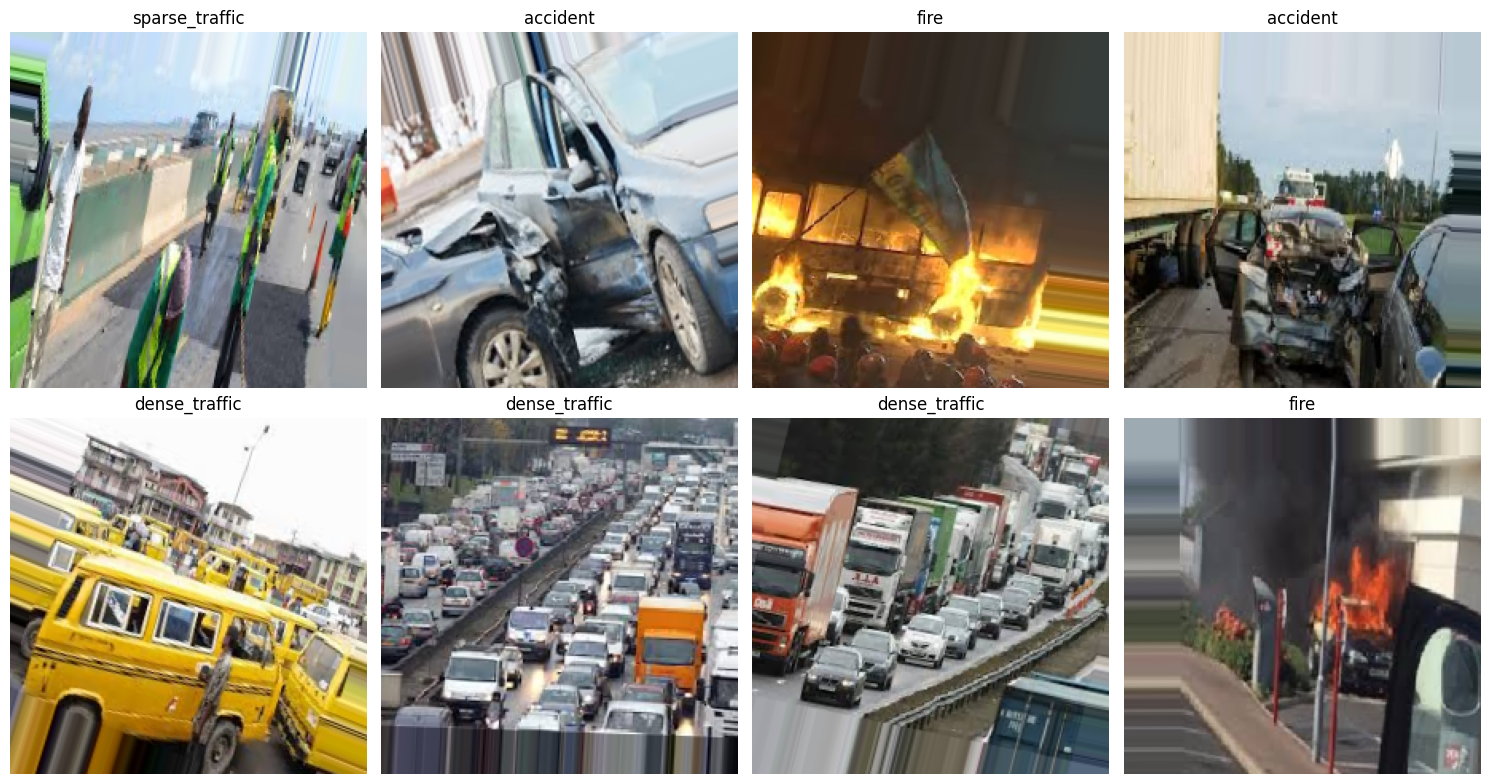

In [16]:
# ============================================================================
# 3. DATA PREPROCESSING & AUGMENTATION
# ============================================================================

# Data Augmentation for training (to prevent overfitting)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% for validation
)

# Only rescaling for validation and test
test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Create data generators
wanted = ["sparse_traffic", "dense_traffic", "accident", "fire"]
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    classes=wanted,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    classes=wanted,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    classes=wanted,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\n{'='*60}")
print("DATA GENERATORS CREATED")
print(f"{'='*60}")
print(f"Training batches: {len(train_generator)}")
print(f"Validation batches: {len(validation_generator)}")
print(f"Test batches: {len(test_generator)}")
print(f"Train class indices: {train_generator.class_indices}")
print(f"Validation class indices: {validation_generator.class_indices}")
print(f"Test class indices: {test_generator.class_indices}")

# Visualize sample images
def plot_sample_images(generator, num_images=8):

    # get a batch (handle iterator exhaustion)
    try:
        images, labels = next(generator)
    except StopIteration:
        generator = iter(generator)
        images, labels = next(generator)

    plt.figure(figsize=(15, 8))
    n = min(num_images, len(images))

    # debug: uncomment to inspect
    # print('images.shape=', getattr(images, 'shape', None), 'labels.shape=', getattr(labels, 'shape', None))

    for i in range(n):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        # determine class index robustly
        lbl = labels[i]
        if hasattr(lbl, "shape") and getattr(lbl, "ndim", 0) > 0:
            class_idx = int(np.argmax(lbl))
        elif isinstance(lbl, (list, tuple, np.ndarray)):
            class_idx = int(np.argmax(lbl))
        else:
            class_idx = int(lbl)

        # guard against out-of-range indices
        if class_idx < 0 or class_idx >= len(CLASS_NAMES):
            title = f'Class {class_idx}'
        else:
            title = CLASS_NAMES[class_idx]

        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_sample_images(train_generator)

In [ ]:
# ============================================================================
# 4. MODEL CREATION - Transfer Learning with MobileNetV2
# ============================================================================

def create_model(input_shape=(224, 224, 3), num_classes=4):
    """
    Create a CNN model using Transfer Learning with MobileNetV2
    Includes regularization and optimization techniques
    """

    # Load pre-trained MobileNetV2 (without top layers)
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Freeze base model layers initially
    base_model.trainable = False

    # Create new model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model, base_model

NUM_CLASSES = len(train_generator.class_indices)

model, base_model = create_model(input_shape=(224,224,3), num_classes=NUM_CLASSES)

# Compile model with optimizer
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

print(f"\n{'='*60}")
print("MODEL ARCHITECTURE")
print(f"{'='*60}")
model.summary()


MODEL ARCHITECTURE


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,625,476 (10.02 MB)

 Trainable params: 364,420 (1.39 MB)

 Non-trainable params: 2,261,056 (8.63 MB)

In [ ]:
# ============================================================================
# 5. MODEL TRAINING WITH CALLBACKS
# ============================================================================

# Define callbacks
callbacks = [
    # Early stopping
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate on plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),

    # Save best model
    ModelCheckpoint(
        filepath=str(MODEL_DIR / 'best_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print(f"\n{'='*60}")
print("TRAINING MODEL - PHASE 1 (Frozen Base)")
print(f"{'='*60}")

# Train with frozen base model
history_phase1 = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

# ============================================================================
# FINE-TUNING: Unfreeze and train entire model
# ============================================================================

print(f"\n{'='*60}")
print("TRAINING MODEL - PHASE 2 (Fine-tuning)")
print(f"{'='*60}")

# Unfreeze base model
base_model.trainable = True

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

# Continue training
history_phase2 = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

# Save final model
model.save(MODEL_DIR / 'traffic_net_model.h5')
print(f"\nModel saved to {MODEL_DIR / 'traffic_net_model.h5'}")


TRAINING MODEL - PHASE 1 (Frozen Base)
Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.6281 - auc: 0.8399 - loss: 1.6135 - precision: 0.6755 - recall: 0.5745
Epoch 1: val_accuracy improved from -inf to 0.87639, saving model to models/best_model.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 89s 754ms/step - accuracy: 0.6293 - auc: 0.8407 - loss: 1.6103 - precision: 0.6767 - recall: 0.5759 - val_accuracy: 0.8764 - val_auc: 0.9779 - val_loss: 0.9713 - val_precision: 0.9146 - val_recall: 0.8333 - learning_rate: 0.0010
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.8257 - auc: 0.9625 - loss: 1.0705 - precision: 0.8519 - recall: 0.8103
Epoch 2: val_accuracy did not improve from 0.87639
90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 477ms/step - accuracy: 0.8257 - auc: 0.9625 - loss: 1.0706 - precision: 0.8519 - recall: 0.8103 - val_accuracy: 0.8750 - val_auc: 0.9807 - val_loss: 0.9271 - val_precision: 0.9028 - val_recall: 0.8514 - learning_rate: 0.0010
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.8402 - auc: 0.9694 - loss: 1.0114 - precision: 0.8649 - recall: 0.8205
Epoch 3: val_accuracy did not improve from 0.87639
90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 484ms/step - accuracy: 0.8404 - auc: 0.9694 - loss: 1.0112 - precision: 0.8650 - 

90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 474ms/step - accuracy: 0.8697 - auc: 0.9776 - loss: 0.8779 - precision: 0.8836 - recall: 0.8548 - val_accuracy: 0.8806 - val_auc: 0.9834 - val_loss: 0.8251 - val_precision: 0.9043 - val_recall: 0.8667 - learning_rate: 0.0010
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8857 - auc: 0.9809 - loss: 0.8300 - precision: 0.8994 - recall: 0.8683
Epoch 8: val_accuracy improved from 0.88056 to 0.90000, saving model to models/best_model.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 479ms/step - accuracy: 0.8856 - auc: 0.9809 - loss: 0.8301 - precision: 0.8993 - recall: 0.8682 - val_accuracy: 0.9000 - val_auc: 0.9848 - val_loss: 0.7803 - val_precision: 0.9165 - val_recall: 0.8847 - learning_rate: 0.0010
Epoch 9/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.8778 - auc: 0.9816 - loss: 0.8141 - precision: 0.8989 - recall: 0.8633
Epoch 9: val_accuracy did not improve from 0.90000
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 466ms/step - accuracy: 0.8777 - auc: 0.9816 - loss: 0.8144 - precision: 0.8988 - recall: 0.8632 - val_accuracy: 0.8736 - val_auc: 0.9815 - val_loss: 0.8074 - val_precision: 0.8937 - val_recall: 0.8528 - learning_rate: 0.0010
Epoch 10/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8826 - auc: 0.9815 - loss: 0.7930 - precision: 0.9021 - recall: 0.8724
Epoch 10: val_accuracy did not improve from 0.90000
90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 479ms/step - accuracy: 0.8826 - auc: 0.9815 - loss: 0.7931 - precision: 0.9020 

90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 472ms/step - accuracy: 0.8945 - auc: 0.9848 - loss: 0.6837 - precision: 0.9117 - recall: 0.8817 - val_accuracy: 0.9056 - val_auc: 0.9865 - val_loss: 0.6594 - val_precision: 0.9258 - val_recall: 0.8833 - learning_rate: 0.0010
Epoch 16/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.8923 - auc: 0.9837 - loss: 0.6803 - precision: 0.9029 - recall: 0.8756
Epoch 16: val_accuracy did not improve from 0.90556
90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 480ms/step - accuracy: 0.8923 - auc: 0.9837 - loss: 0.6803 - precision: 0.9029 - recall: 0.8756 - val_accuracy: 0.8958 - val_auc: 0.9844 - val_loss: 0.6628 - val_precision: 0.9067 - val_recall: 0.8778 - learning_rate: 0.0010
Epoch 17/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8878 - auc: 0.9828 - loss: 0.6773 - precision: 0.9051 - recall: 0.8752
Epoch 17: val_accuracy did not improve from 0.90556
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 469ms/step - accuracy: 0.8878 - auc: 0.9828 - loss: 0.6773 - precision: 0.905

90/90 ━━━━━━━━━━━━━━━━━━━━ 46s 512ms/step - accuracy: 0.9222 - auc: 0.9915 - loss: 0.5381 - precision: 0.9310 - recall: 0.9166 - val_accuracy: 0.9208 - val_auc: 0.9913 - val_loss: 0.5511 - val_precision: 0.9280 - val_recall: 0.9125 - learning_rate: 5.0000e-06
Epoch 18/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.9210 - auc: 0.9919 - loss: 0.5299 - precision: 0.9314 - recall: 0.9133
Epoch 18: val_accuracy did not improve from 0.92083
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 521ms/step - accuracy: 0.9210 - auc: 0.9919 - loss: 0.5300 - precision: 0.9314 - recall: 0.9133 - val_accuracy: 0.9083 - val_auc: 0.9876 - val_loss: 0.5878 - val_precision: 0.9129 - val_recall: 0.9028 - learning_rate: 5.0000e-06
Epoch 19/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9230 - auc: 0.9912 - loss: 0.5372 - precision: 0.9327 - recall: 0.9157
Epoch 19: val_accuracy did not improve from 0.92083
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 520ms/step - accuracy: 0.9230 - auc: 0.9912 - loss: 0.5373 - precisio

90/90 ━━━━━━━━━━━━━━━━━━━━ 46s 513ms/step - accuracy: 0.9314 - auc: 0.9906 - loss: 0.5395 - precision: 0.9397 - recall: 0.9248 - val_accuracy: 0.9264 - val_auc: 0.9917 - val_loss: 0.5369 - val_precision: 0.9312 - val_recall: 0.9208 - learning_rate: 1.2500e-06
Epoch 28/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9283 - auc: 0.9910 - loss: 0.5301 - precision: 0.9373 - recall: 0.9240
Epoch 28: val_accuracy did not improve from 0.92639
90/90 ━━━━━━━━━━━━━━━━━━━━ 46s 512ms/step - accuracy: 0.9283 - auc: 0.9910 - loss: 0.5301 - precision: 0.9372 - recall: 0.9240 - val_accuracy: 0.9111 - val_auc: 0.9902 - val_loss: 0.5626 - val_precision: 0.9217 - val_recall: 0.8986 - learning_rate: 1.2500e-06
Epoch 29/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.9261 - auc: 0.9918 - loss: 0.5253 - precision: 0.9332 - recall: 0.9190
Epoch 29: val_accuracy did not improve from 0.92639
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 518ms/step - accuracy: 0.9262 - auc: 0.9918 - loss: 0.5253 - precisio


Model saved to models/traffic_net_model.h5


In [19]:
# ============================================================================
# 6. MODEL EVALUATION - COMPREHENSIVE METRICS
# ============================================================================

print(f"\n{'='*60}")
print("MODEL EVALUATION")
print(f"{'='*60}")

# Evaluate on test set
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)

print(f"\nTest Results:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall: {test_recall:.4f}")
print(f"  AUC: {test_auc:.4f}")

# Calculate F1 Score
f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print(f"  F1 Score: {f1:.4f}")

# Get predictions
test_generator.reset()
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Detailed classification report
print(f"\n{'='*60}")
print("CLASSIFICATION REPORT")
print(f"{'='*60}")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))


MODEL EVALUATION
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9283 - auc: 0.9904 - loss: 0.5466 - precision: 0.9312 - recall: 0.9210

Test Results:
  Loss: 0.5702
  Accuracy: 0.9212
  Precision: 0.9267
  Recall: 0.9162
  AUC: 0.9877
  F1 Score: 0.9214
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step

CLASSIFICATION REPORT
                precision    recall  f1-score   support

sparse_traffic       0.85      0.94      0.89       200
 dense_traffic       0.96      0.91      0.93       200
      accident       0.91      0.91      0.91       200
          fire       0.98      0.93      0.95       200

      accuracy                           0.92       800
     macro avg       0.92      0.92      0.92       800
  weighted avg       0.92      0.92      0.92       800



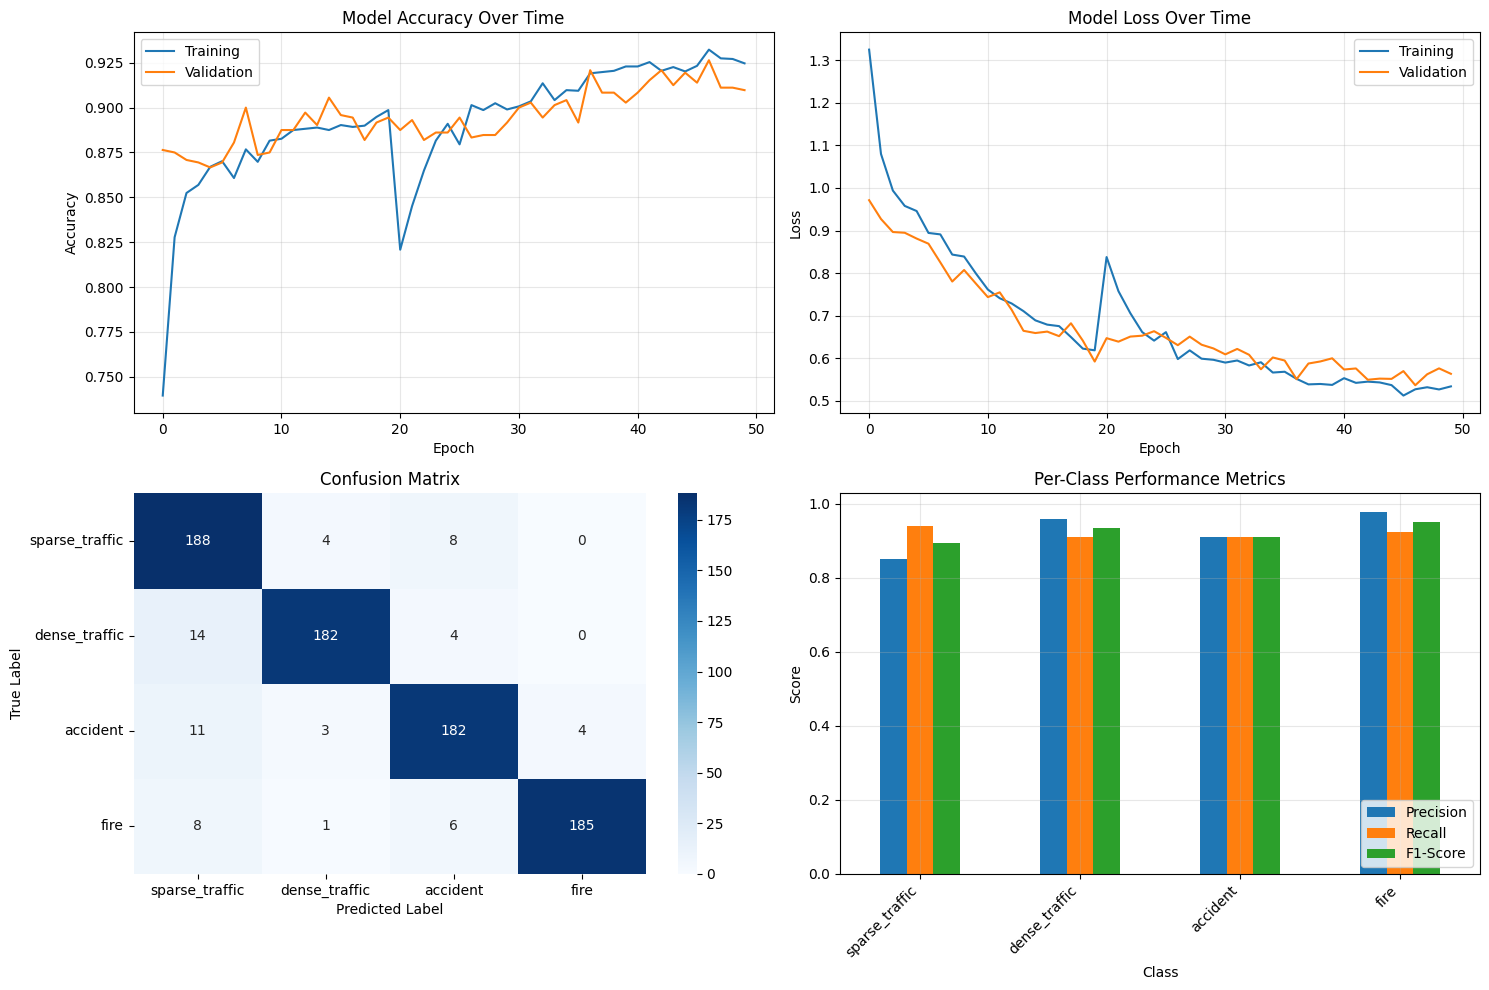

/tmp/ipython-input-3667256876.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(CLASS_NAMES, rotation=45, ha='right')


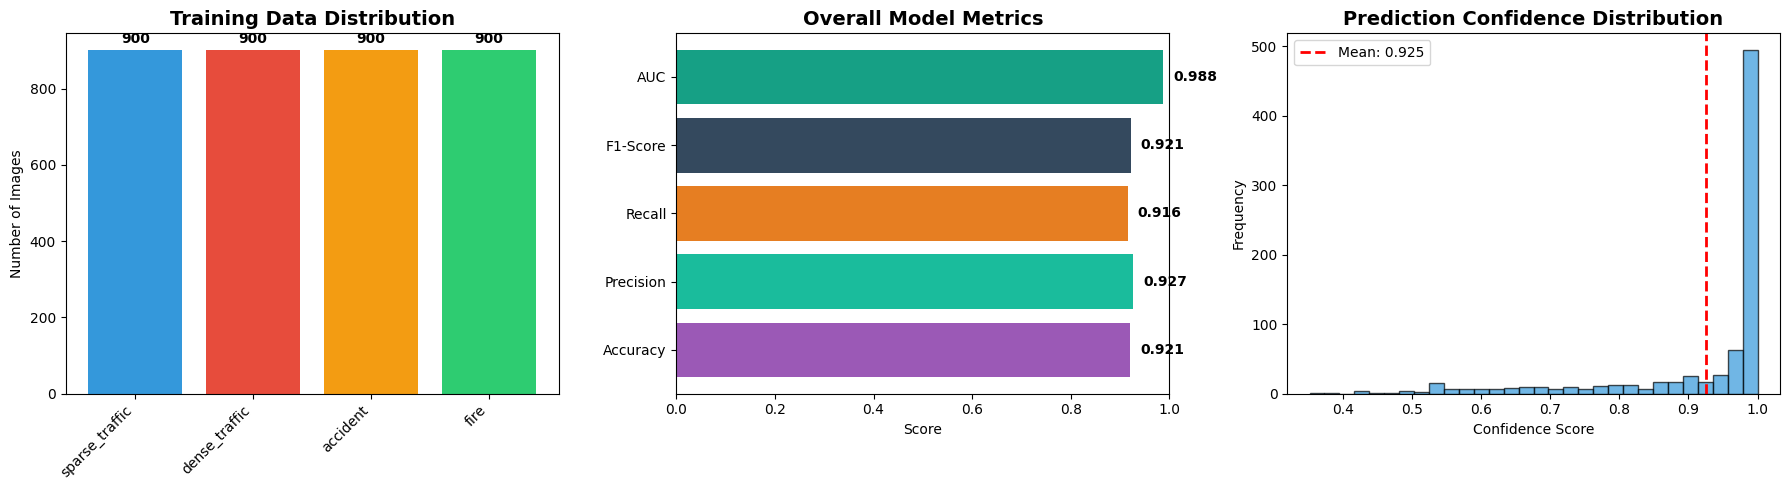

In [20]:
# ============================================================================
# 7. VISUALIZATIONS
# ============================================================================

# Plot 1: Training History
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Combine both training phases
all_history = {
    'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
    'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy'],
    'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
    'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss']
}

# Accuracy
axes[0, 0].plot(all_history['accuracy'], label='Training')
axes[0, 0].plot(all_history['val_accuracy'], label='Validation')
axes[0, 0].set_title('Model Accuracy Over Time')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(all_history['loss'], label='Training')
axes[0, 1].plot(all_history['val_loss'], label='Validation')
axes[0, 1].set_title('Model Loss Over Time')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix')
axes[1, 0].set_ylabel('True Label')
axes[1, 0].set_xlabel('Predicted Label')

# Class-wise Performance
metrics_df = pd.DataFrame({
    'Precision': precision_score(y_true, y_pred, average=None),
    'Recall': recall_score(y_true, y_pred, average=None),
    'F1-Score': f1_score(y_true, y_pred, average=None)
}, index=CLASS_NAMES)

metrics_df.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Per-Class Performance Metrics')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_xlabel('Class')
axes[1, 1].legend(loc='lower right')
axes[1, 1].set_xticklabels(CLASS_NAMES, rotation=45, ha='right')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot 2: Dataset Insights
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Class Distribution
class_counts = list(train_counts.values())
axes[0].bar(CLASS_NAMES, class_counts, color=['#3498db', '#e74c3c', '#f39c12', '#2ecc71'])
axes[0].set_title('Training Data Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Images')
axes[0].set_xticklabels(CLASS_NAMES, rotation=45, ha='right')
for i, v in enumerate(class_counts):
    axes[0].text(i, v + 20, str(v), ha='center', fontweight='bold')

# Model Performance Comparison
metrics_comparison = {
    'Accuracy': test_accuracy,
    'Precision': test_precision,
    'Recall': test_recall,
    'F1-Score': f1,
    'AUC': test_auc
}
axes[1].barh(list(metrics_comparison.keys()), list(metrics_comparison.values()),
             color=['#9b59b6', '#1abc9c', '#e67e22', '#34495e', '#16a085'])
axes[1].set_title('Overall Model Metrics', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Score')
axes[1].set_xlim([0, 1])
for i, (k, v) in enumerate(metrics_comparison.items()):
    axes[1].text(v + 0.02, i, f'{v:.3f}', va='center', fontweight='bold')

# Prediction Confidence Distribution
confidence_scores = np.max(y_pred_probs, axis=1)
axes[2].hist(confidence_scores, bins=30, color='#3498db', edgecolor='black', alpha=0.7)
axes[2].set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Confidence Score')
axes[2].set_ylabel('Frequency')
axes[2].axvline(np.mean(confidence_scores), color='red', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(confidence_scores):.3f}')
axes[2].legend()

plt.tight_layout()
plt.savefig('dataset_insights.png', dpi=150, bbox_inches='tight')
plt.show()

In [21]:
# ============================================================================
# 8. PREDICTION FUNCTION
# ============================================================================

def predict_image(image_path, model, show_plot=True):
    """
    Predict the class of a single image
    """
    # Load and preprocess image
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, IMG_SIZE)
    img_array = img_resized / 255.0
    img_batch = np.expand_dims(img_array, axis=0)

    # Make prediction
    predictions = model.predict(img_batch, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = CLASS_NAMES[predicted_class_idx]
    confidence = predictions[0][predicted_class_idx]

    if show_plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Show image
        ax1.imshow(img_resized)
        ax1.set_title(f'Predicted: {predicted_class}\nConfidence: {confidence:.2%}')
        ax1.axis('off')

        # Show prediction probabilities
        ax2.barh(CLASS_NAMES, predictions[0])
        ax2.set_xlabel('Probability')
        ax2.set_title('Class Probabilities')
        ax2.set_xlim([0, 1])

        plt.tight_layout()
        plt.show()

    return {
        'class': predicted_class,
        'confidence': float(confidence),
        'all_probabilities': {CLASS_NAMES[i]: float(predictions[0][i]) for i in range(len(CLASS_NAMES))}
    }

# Test prediction function
print(f"\n{'='*60}")
print("TEST PREDICTION")
print(f"{'='*60}")
# predict_image('path/to/test/image.jpg', model)


TEST PREDICTION


In [ ]:
# ============================================================================
# 9. SAVE MODEL METADATA
# ============================================================================

metadata = {
    'model_name': 'Traffic-Net Classifier',
    'version': '1.0',
    'created_at': datetime.now().isoformat(),
    'architecture': 'MobileNetV2 + Custom Layers',
    'input_shape': list(IMG_SIZE) + [3],
    'num_classes': len(CLASS_NAMES),
    'class_names': CLASS_NAMES,
    'metrics': {
        'test_accuracy': float(test_accuracy),
        'test_precision': float(test_precision),
        'test_recall': float(test_recall),
        'test_f1_score': float(f1),
        'test_auc': float(test_auc),
        'test_loss': float(test_loss)
    },
    'training_samples': train_total,
    'test_samples': test_total
}

with open(MODEL_DIR / 'model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"\nModel metadata saved to {MODEL_DIR / 'model_metadata.json'}")

# Save class indices
with open(MODEL_DIR / 'class_indices.pkl', 'wb') as f:
    pickle.dump(train_generator.class_indices, f)

print("\n" + "="*60)
print("PIPELINE COMPLETE!")
print("="*60)
print(f"✓ Model trained and saved")
print(f"✓ Evaluation metrics calculated")
print(f"✓ Visualizations generated")
print(f"✓ Metadata saved")
print(f"\nFinal Test Accuracy: {test_accuracy:.2%}")
print("="*60)


Model metadata saved to models/model_metadata.json

PIPELINE COMPLETE!
✓ Model trained and saved
✓ Evaluation metrics calculated
✓ Visualizations generated
✓ Metadata saved

Final Test Accuracy: 92.12%
